In [1]:
import collections
import os
import warnings
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmeta.datasets.helpers import omniglot
from torchmeta.modules import MetaBatchNorm2d, MetaConv2d, MetaLinear, MetaModule, MetaSequential
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

from torchmeta.datasets.helpers import fc100
from torchmeta.transforms import Categorical, ClassSplitter
from torchvision.transforms import Compose, Resize, ToTensor
import multiprocessing

try:
    multiprocessing.set_start_method("spawn")
except RuntimeError:
    print("The start method has already been set.")

warnings.filterwarnings("ignore")

In [2]:
from torchmeta.utils.data import Task

def apply_transforms(task, transforms):
    print("Before transformation:", task)
    if isinstance(task, Task):
        task = transforms(task)
    print("After transformation:", task)
    return task

In [3]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:

    # Set transforms
    train_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    val_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    # class_splitter = ClassSplitter(shuffle=True, num_train_per_class=config["num_shots"], num_test_per_class=config["test_shots"])

    train_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_train=True,
        transform=train_transforms,
        target_transform=Categorical(config["num_ways"]),
        # dataset_transform=class_splitter,
        download=config["download"],
    )
    val_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_val=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )
    test_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_test=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )

    # train_dataset = class_splitter(train_dataset)
    # val_dataset = class_splitter(val_dataset)
    # test_dataset = class_splitter(test_dataset)
    train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)

    return train_dataloader, val_dataloader, test_dataloader


In [4]:

config = {
    "folder_name": "data/FC1006",
    "num_shots": 5,
    "test_shots": 15,
    "num_ways": 5,
    "task_batch_size":2,
    "download": True,
    "image_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_task_batch_train": 100,  # Add this line with the desired value
    "num_task_batch_test": 20,
    "num_task_batch_val": 10,
    "output_folder": "output",     # Add this line for the output_folder key
}


train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

In [5]:
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx >= config["num_task_batch_train"]:
        break

    support_xs = batch["train"][0].to(device=config["device"])
    support_ys = batch["train"][1].to(device=config["device"])
    query_xs = batch["test"][0].to(device=config["device"])
    query_ys = batch["test"][1].to(device=config["device"])
 
    print(
        f"support_x shape : {support_xs.shape}\n",
        f"support_y shape : {support_ys.shape}\n",
        f"query_x shape   : {query_xs.shape}\n",
        f"query_y shape   : {query_ys.shape}",
    )

    break

support_x shape : torch.Size([2, 25, 3, 32, 32])
 support_y shape : torch.Size([2, 25])
 query_x shape   : torch.Size([2, 25, 3, 32, 32])
 query_y shape   : torch.Size([2, 25])


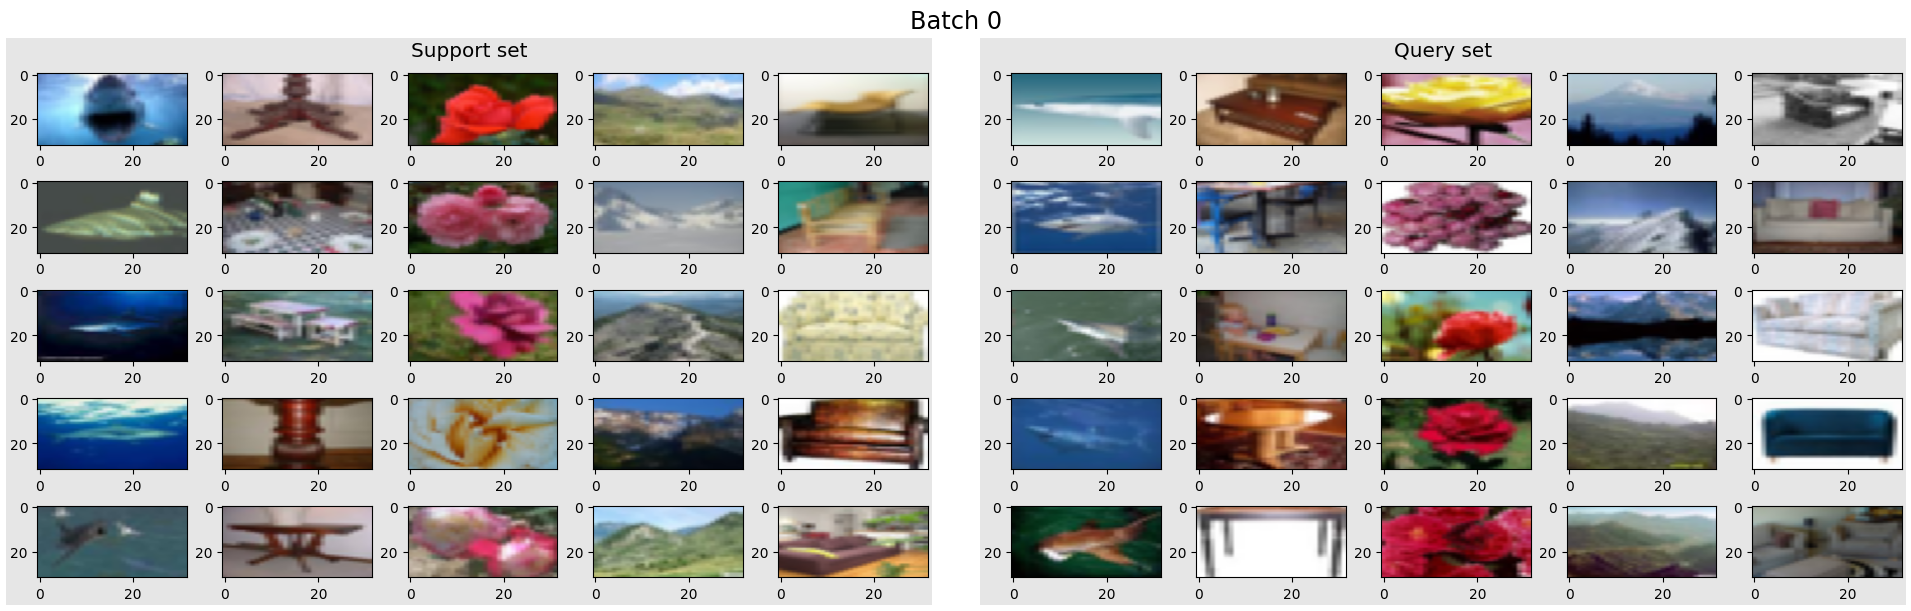

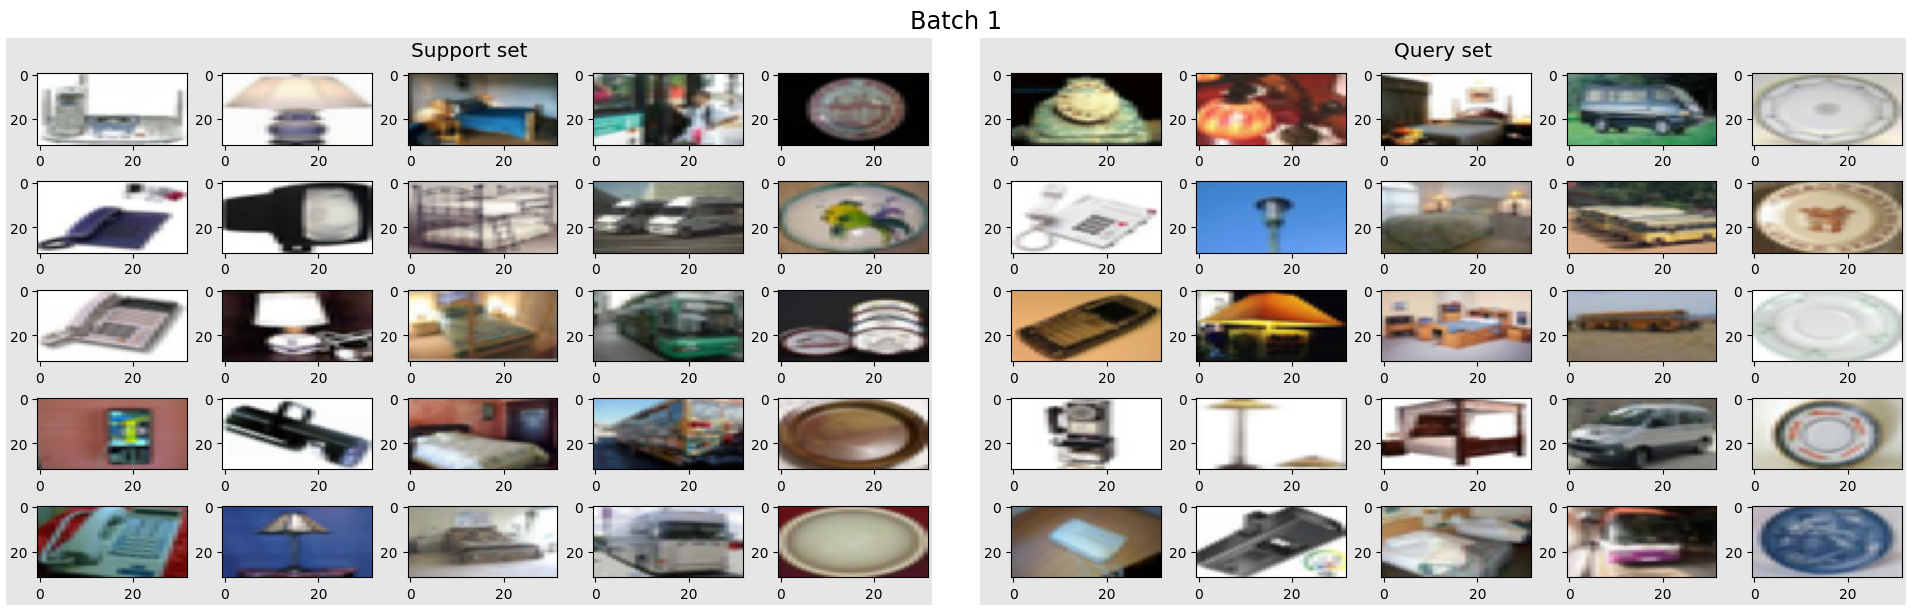

In [26]:
for b in range(config["task_batch_size"]):
    fig = plt.figure(constrained_layout=True, figsize=(19, 6))
    subfigs = fig.subfigures(1, 2, wspace=0.05)

    subfigs[0].set_facecolor("0.9")
    subfigs[0].suptitle("Support set", fontsize="x-large")
    support_axs = subfigs.flat[0].subplots(nrows=5, ncols=5)
    for i, ax in enumerate(support_axs.T.flatten()):
        ax.imshow(support_xs[b][i].cpu().permute(1, 2, 0).squeeze(), aspect="auto")

    subfigs[1].set_facecolor("0.9")
    subfigs[1].suptitle("Query set", fontsize="x-large")
    query_axes = subfigs.flat[1].subplots(nrows=5, ncols=5)
    for i, ax in enumerate(query_axes.T.flatten()):
        ax.imshow(query_xs[b][i].cpu().permute(1, 2, 0).squeeze(), aspect="auto")

    fig.suptitle("Batch " + str(b), fontsize="xx-large")

    plt.show()